$$ % Latex macros
\newcommand{\mat}[1]{\begin{pmatrix} #1 \end{pmatrix}}
\newcommand{\p}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\b}[1]{\boldsymbol{#1}}
\newcommand{\w}{\boldsymbol{w}}
\newcommand{\x}{\boldsymbol{x}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from scipy.stats import ttest_ind
import random
%matplotlib inline

In [2]:
from matplotlib.patches import Rectangle
from collections import defaultdict
from itertools import combinations
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import chi2_contingency

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'xtick.major.size': 2,
    'xtick.minor.size': 2,
    'xtick.minor.width': 0.5,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    'ytick.major.size': 2,
    'ytick.minor.size': 2,
})

In [4]:
np.random.seed(42)

# Define parameters

In [5]:
env_type = "LeverPushPullTrial"
opto = ""  # Optogenetic stimulation target: "L2IT" or "L5IT"
num_repeats = 1000


time_steps = 8
ns = Ns = 2*5 # push/pull*position
na = Na = 2  # push/pull
# Define reward model
R = np.zeros((ns, na))
R[0,:] = R[-1,:] = 1.0

# Classes for minimum environment and agent

In [6]:
class Environment:
    """Class for a reinforcement learning environment"""

    def __init__(self, nstate=3, naction=2):
        """Initialize environment with given number of states and actions"""
        self.Ns = nstate   # Number of states
        self.Na = naction  # Number of actions
        self.step_count = 0

    def start(self):
        """Start a new episode by randomly selecting an initial state"""
        self.state = np.random.randint(self.Ns)
        return self.state

    def step(self, action):
        """Take a step by executing the given action

        Returns:
            reward (float): random reward between 0 and 1
            next_state (int): randomly selected next state
        """
        self.reward = np.random.random()  # Reward in [0, 1)
        self.state = np.random.randint(self.Ns)
        return self.reward, self.state

In [7]:
class Agent:
    """Class for a reinforcement learning agent"""

    def __init__(self, nstate, naction):
        """Initialize agent with given number of states and actions"""
        self.Ns = nstate   # Number of states
        self.Na = naction  # Number of actions

    def start(self, state):
        """Select an initial action without reward feedback

        Args:
            state (int): current state

        Returns:
            action (int): selected action
        """
        self.action = np.random.randint(self.Na)
        return self.action

    def step(self, reward, state):
        """Select an action based on received reward and new state

        Args:
            reward (float): received reward
            state (int): current state

        Returns:
            action (int): selected action
        """
        # No learning implemented; action is chosen randomly
        self.action = np.random.randint(self.Na)
        return self.action

In [8]:
class RL:
    """Reinforcement learning via interaction between Environment and Agent"""

    def __init__(self, environment, agent, nstate, naction, env_type, tmax, opto):
        """Initialize environment and agent"""
        self.env = environment(nstate, naction)
        self.agent = agent(nstate, naction, T=tmax, env_type=env_type, opto=opto)

    def episode(self, tmax=50):
        """Run a single episode (standard agent behavior)"""
        state = self.env.start()
        action = self.agent.start(state)

        # Record of [time, reward, state, action]
        Trsa = []
        Trsa.append([0, 0, state, action])

        # Interaction loop
        for t in range(1, tmax + 1):
            reward, state, done = self.env.step(action)
            if done:
                action = self.agent.step(reward, state, done=True)
                Trsa.append([t, reward, state, action])
                break
            action = self.agent.step(reward, state, done=False)
            Trsa.append([t, reward, state, action])
        return np.array(Trsa)

    def episode2(self, tmax=50):
        state = self.env.start()
        action = self.agent.start(state)

        Trsa = []
        Trsa.append([0, 0, state, action])

        for t in range(1, tmax + 1):
            reward, state, done = self.env.step(action)
            if done:
                action = self.agent.step2(reward, state, done=True)
                Trsa.append([t, reward, state, action])
                break
            action = self.agent.step2(reward, state, done=False)
            Trsa.append([t, reward, state, action])

        return np.array(Trsa)

    def run(self, nrun=10, tmax=50):
        """Run multiple episodes and return total reward for each run"""
        Return = np.zeros(nrun)
        for n in range(nrun):
            rewards = self.episode(tmax)[:, 1]
            Return[n] = rewards.sum()
        return Return

    def run2(self, nrun=10, tmax=50):
        """Run multiple episodes and return total reward and initial state"""
        Return = np.zeros(nrun)
        State = np.zeros(nrun)
        for n in range(nrun):
            trsa = self.episode(tmax)
            Return[n] = trsa[:, 1].sum()
            State[n] = trsa[0, 2]
        return Return, State

### Example: Lever Push Pull Trial

In [9]:
class LeverPushPullTrial(Environment):

    def __init__(self, nstate, naction, pushpull=None, level=None):
        """
        Args:
            nstate (int): number of states
            naction (int): number of actions
        """
        super().__init__(nstate=nstate, naction=naction)
        # Define reward function as a matrix
        self.R = np.zeros((nstate,naction))
        self.R[0,:] = self.R[-1,:] = 1.0

        self.pushpull = np.random.randint(0,2) if pushpull is None else pushpull
        self.level = np.random.choice([0, 1, 2], p=[0.5, 0.25, 0.25]) if level is None else level

    def build_transition_matrix(self):
        """
        Build transition matrix T[s, a] for all state-action pairs.
        If movement is invalid (into wall), remain in the same state.
        """
        T = np.zeros((self.Ns, self.Na), dtype=int)
        T[5:,1] = 9
        if self.level == 0:
            T[:5,1] = np.arange(0,5,1)
            T[5:,0] = np.arange(5,10,1)
        elif self.level == 1:
            T[:4,1] = np.arange(1,5,1)
            T[4,1]  = 4
            T[6:,0] = np.arange(5,9,1)
            T[5,0]  = 5
        elif self.level == 2:
            T[:5,1] = 4
            T[5:,0] = 5

        return T

    def start(self):
        """Start a new episode at the fixed initial state (0, 0)"""
        self.state = 2 if self.pushpull == 0 else 7
        self.transition_matrix = self.build_transition_matrix()
        return self.state

    def step(self, action):
        """
        Perform an action and return reward, next state, and done flag.

        """
        next_state = self.transition_matrix[self.state, action]
        self.state = next_state
        done = (self.state in (0,4,5,9))
        reward = self.R[self.state, action]

        return reward, self.state, done

### Clasees for example agents

In [10]:
class CAI(Agent):

    def __init__(self, nstate, naction, T=200, env_type="LeverPushPullTrial",
                 opto=None, switch_step=15, pushpull=None,level=None):
        super().__init__(nstate, naction)

        self.beta = 10
        self.opto = opto

        self.T = T
        self.switch_step = switch_step
        self.step_count = 0

        # Initialize value, Q, and Advantage tables
        self.V = np.zeros(nstate)
        self.Q = np.zeros((nstate, naction))
        self.Advantage = np.zeros((nstate, naction))

        self.R = np.zeros((nstate, naction))
        self.pushpull = np.random.randint(0,2) if pushpull is None else pushpull
        self.level = np.random.choice([0, 1, 2], p=[0.5, 0.25, 0.25]) if level is None else level
        self.R[0,:] = self.R[-1,:] = 1.0
        self.mean_reward = np.mean(self.R)

        # Logging variables
        self.logged_action_value = []
        self.logged_next_state_prediction = []
        self.logged_reward_next = []
        self.logged_state_value = []
        self.logged_advantage = []
        self.logged_action = []
        self.logged_action_value_all = []
        self.logged_next_state_prediction_all = []
        self.logged_reward_next_all = []
        self.logged_state_value_all = []
        self.logged_advantage_all = []
        self.logged_next_states_one_hot = []
        self.logged_action_one_hot = []

    def build_transition_matrix(self):
        T = np.zeros((self.Ns, self.Na), dtype=int)
        T[5:,1] = 9
        if self.level == 0:
            T[:5,1] = np.arange(0,5,1)
            T[5:,0] = np.arange(5,10,1)
        elif self.level == 1:
            T[:4,1] = np.arange(1,5,1)
            T[4,1]  = 4
            T[6:,0] = np.arange(5,9,1)
            T[5,0]  = 5
        elif self.level == 2:
            T[:5,1] = 4
            T[5:,0] = 5

        return T

    def boltzmann(self, q):
        """Boltzmann (softmax) action selection"""
        p = np.exp(self.beta * q)
        p = np.clip(p, 1e-10, None)
        p_sum = np.sum(p)
        if p_sum <= 1e-10:
            p = np.ones_like(q) / len(q)
        else:
            p = p / p_sum
        sample = np.random.multinomial(1, p)
        return np.argmax(sample)

    def _log_state(self, state, next_states, rewards):
        self.logged_action_value.append(self.Q[state, :].copy())
        self.logged_next_state_prediction.append(next_states.copy())
        self.logged_reward_next.append(rewards.copy())
        self.logged_state_value.append(self.V[state].copy())
        self.logged_advantage.append(self.Advantage[state, :].copy())
        self.logged_action.append(self.action)
        self.logged_action_value_all.append(self.Q.flatten())
        self.logged_state_value_all.append(self.V.copy())
        self.logged_advantage_all.append(self.Advantage.flatten())

        self.logged_next_state_prediction_all.append(self.transition_matrix.flatten())

        self.logged_reward_next_all.append(self.R[state, :].flatten())

        action_one_hot = np.zeros(self.Na, dtype=np.int64)
        action_one_hot[self.action] = 1
        self.logged_action_one_hot.append(action_one_hot)

        next_states_one_hot = np.zeros(self.Ns * self.Na, dtype=np.int64)
        for a in range(self.Na):
            idx = next_states[a] * self.Na + a
            next_states_one_hot[int(idx)] = 1
        self.logged_next_states_one_hot.append(next_states_one_hot)


    def start(self, state):
        """Initial action """
        self.state = state
        self.transition_matrix = self.build_transition_matrix()
        state_switch_rnd = random.random()
        if (self.level == 0 and state_switch_rnd > 0.914) or (self.level == 1 and state_switch_rnd > 0.804) or (self.level == 2 and state_switch_rnd > 0.671):
            state = (state+5)%10
        if opto in ("L2IT","L5IT"):
            adv_raw = self.Q[state,:] - self.V[state]
            self.Advantage[state, :] = np.clip(adv_raw, -100, 100)
        self.action = self.boltzmann(self.Advantage[state, :])
        self._log_state(state, np.zeros_like(self.transition_matrix[state]), np.zeros_like(self.R[state]))
        return self.action

    def step(self, reward, state, done=False):
        self.state = state
        state_switch_rnd = random.random()
        if (self.level == 0 and state_switch_rnd > 0.914) or (self.level == 1 and state_switch_rnd > 0.804) or (self.level == 2 and state_switch_rnd > 0.671):
            state = (state+5)%10

        next_states = self.transition_matrix[state, :].astype(np.int64)
        rewards = self.R[state, :]

        self.Q[state, :] = rewards - self.mean_reward + self.V[next_states]

        log_q = self.Q[state, :]
        log_w = self.Advantage[state, :]
        self.V[state] = logsumexp(log_q + log_w) - logsumexp(log_w)

        adv_raw = self.Q[state, :] - self.V[state]
        self.Advantage[state, :] = np.clip(adv_raw, -100, 100)

        self.action = self.boltzmann(self.Advantage[state, :])

        self._log_state(state, next_states, rewards)

        return self.action

    def step2(self, reward, state, done=False):
        self.state = state
        state_switch_rnd = random.random()
        if (self.level == 0 and state_switch_rnd > 0.914) or (self.level == 1 and state_switch_rnd > 0.804) or (self.level == 2 and state_switch_rnd > 0.671):
            state = (state+5)%10

        next_states = self.transition_matrix[state, :].astype(np.int64)
        rewards = self.R[state, :]

        # Q update
        if opto == "L2IT":
            self.Q[:, :] = 0
        else:
            self.Q[state, :] = rewards - self.mean_reward + self.V[next_states]

        # V update
        if opto == "L5IT":
            self.V[:] = 0
        else:
            log_q = self.Q[state, :]
            log_w = self.Advantage[state, :]
            self.V[state] = logsumexp(log_q + log_w) - logsumexp(log_w)

        adv_raw = self.Q[state, :] - self.V[state]
        self.Advantage[state, :] = np.clip(adv_raw, -100, 100)

        self.action = self.boltzmann(self.Advantage[state, :])

        self._log_state(state, next_states, rewards)
        return self.action

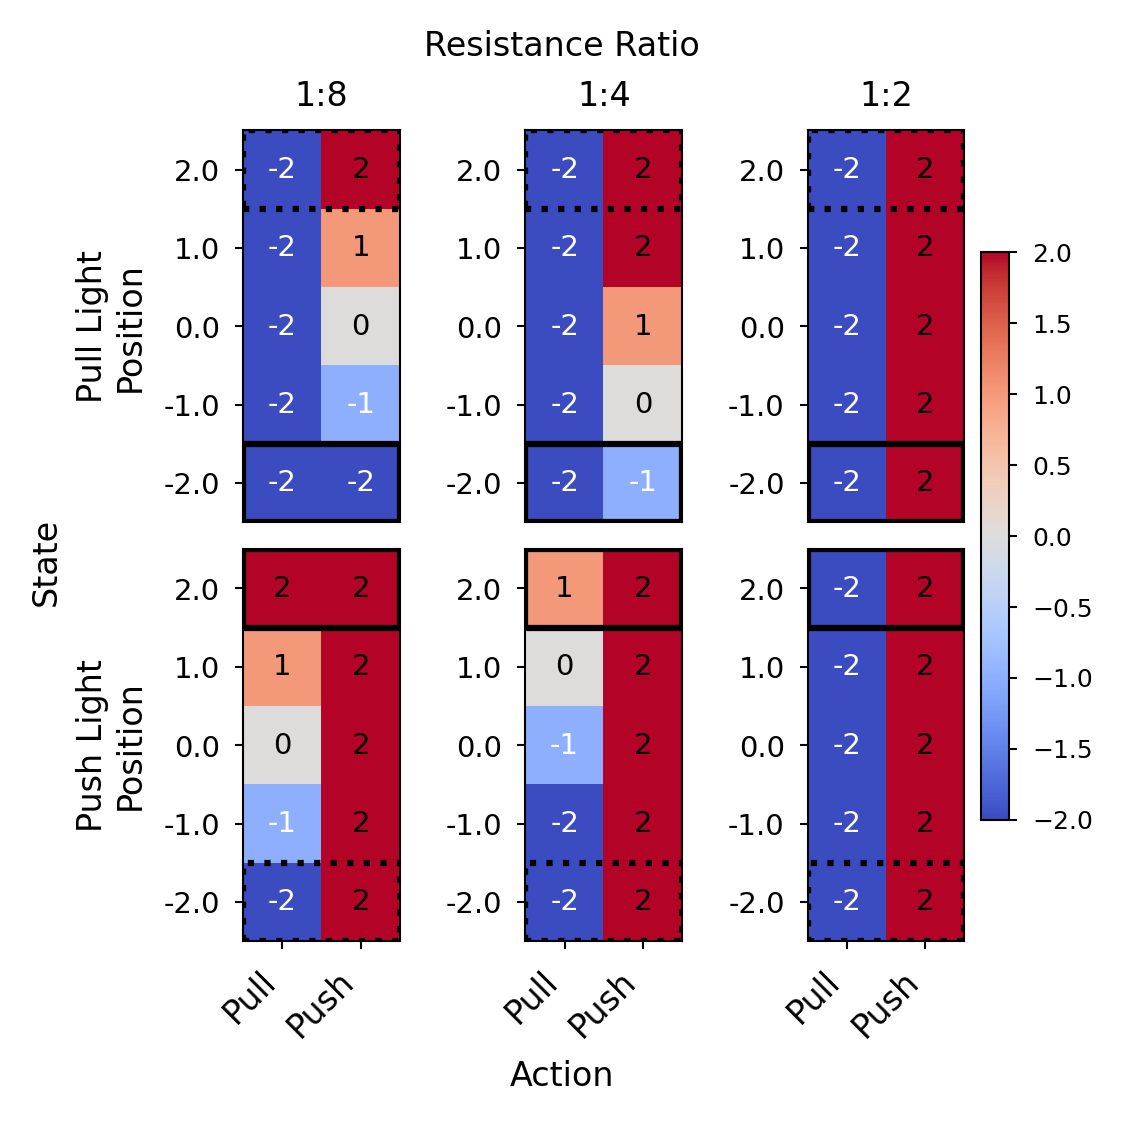

In [11]:

Ns = 10  # number of states
Na = 2   # number of actions

# Create T matrices for each level
T_matrices = {}
for level in range(3):
    T = np.zeros((Ns, Na), dtype=int)
    T[5:,1] = 9
    if level == 0:
        T[:5,1] = np.arange(0,5,1)
        T[5:,0] = np.arange(5,10,1)
    elif level == 1:
        T[:4,1] = np.arange(1,5,1)
        T[4,1]  = 4
        T[6:,0] = np.arange(5,9,1)
        T[5,0]  = 5
    elif level == 2:
        T[:5,1] = 4
        T[5:,0] = 5
    T_matrices[level] = T

def plot_on_ax(ax, matrix, cmap, vmin, vmax, y_labels, highlight_rows={}):
    im = ax.imshow(matrix, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)

    for s in range(matrix.shape[0]):
        for a in range(matrix.shape[1]):
            val = matrix[s, a]
            mid_point = (vmax + vmin) / 2
            text_color = 'white' if val < mid_point else 'black'
            ax.text(a, s, f"{int(val)}", ha='center', va='center', color=text_color, fontsize=7)

    for row_idx, style in highlight_rows.items():
        rect = Rectangle((-0.5, row_idx - 0.5), Na, 1,
                         facecolor='none', edgecolor=style['color'],
                         linestyle=style['linestyle'], linewidth=1.5, zorder=10)
        ax.add_patch(rect)

    ax.set_yticks(ticks=np.arange(matrix.shape[0]), labels=y_labels, fontsize=7)
    ax.invert_yaxis()
    return im

fig, axes = plt.subplots(2, 3, figsize=(3.6, 3.6), dpi=300, constrained_layout=True)

column_titles = ['1:8', '1:4', '1:2']
y_labels_range = [f"{v:.1f}" for v in np.linspace(-2, 2, 5)]

for level in range(3):
    T_matrix = T_matrices[level]

    ax_pos = axes[0, level]
    matrix_pos = T_matrix[:5, :] - 2
    im = plot_on_ax(ax_pos, matrix_pos,
                    cmap='coolwarm', vmin=-2, vmax=2,
                    y_labels=y_labels_range,
                    highlight_rows={0: {'color': 'black', 'linestyle': 'solid'},
                                    4: {'color': 'black', 'linestyle': 'dotted'}})
    ax_pos.set_title(column_titles[level], fontsize=8)

    ax_force = axes[1, level]
    matrix_force = T_matrix[5:, :] - 7
    plot_on_ax(ax_force, matrix_force,
               cmap='coolwarm', vmin=-2, vmax=2,
               y_labels=y_labels_range,
               highlight_rows={0: {'color': 'black', 'linestyle': 'dotted'},
                               4: {'color': 'black', 'linestyle': 'solid'}})

    if level == 0:
        ax_pos.set_ylabel("Pull Light\nPosition", fontsize=8)
        ax_force.set_ylabel("Push Light\nPosition", fontsize=8)

    ax_pos.set_xticks([])
    ax_force.set_xticks(ticks=np.arange(Na), labels=["Pull", "Push"], fontsize=8, rotation=45, ha='right')

fig.suptitle('Resistance Ratio', fontsize=8)
fig.supxlabel("Action", fontsize=8)
fig.supylabel("State", fontsize=8)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, pad=0.02)
cbar.ax.tick_params(labelsize=6)

fig.set_constrained_layout_pads(w_pad=2./72., h_pad=2./72., wspace=0.05, hspace=0.05)

plt.savefig("T_heatmap_grid_adjusted.svg", format="svg")
plt.show()
plt.close()

# CAI simulation

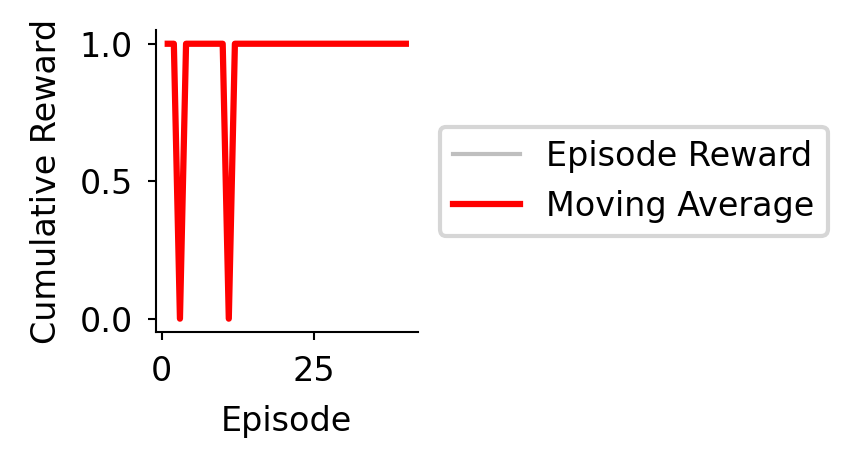

In [12]:

num_episodes = 40
tmax = 8
cumulative_rewards = []
# Initialize environment and agent
pgq_grid = RL(LeverPushPullTrial, CAI, 10, 2, env_type="LeverPushPullTrial", tmax=100, opto=None)
pushpulls = np.random.randint(0,2,num_episodes)
levels = np.random.choice([0, 1, 2], size=num_episodes, p=[0.5, 0.25, 0.25])
pgq_grid.agent.beta = 10

all_action_values, all_next_state_predictions, all_reward_next = [], [], []
all_state_values, all_advantages, all_actions = [], [], []
episode_lengths = []

# Training loop
for ep in range(1, num_episodes + 1):
    pgq_grid.agent.pushpull = pushpulls[ep-1]
    pgq_grid.agent.level = levels[ep-1]
    pgq_grid.env.pushpull = pushpulls[ep-1]
    pgq_grid.env.level = levels[ep-1]
    trsa = pgq_grid.episode2(tmax=tmax) if opto in ("L2IT", "L5IT") and ep > num_episodes//2 else pgq_grid.episode(tmax=tmax)
    cum_reward = np.sum(trsa[:, 1])
    cumulative_rewards.append(cum_reward)

    all_action_values.append(pgq_grid.agent.logged_action_value_all)
    all_next_state_predictions.append(pgq_grid.agent.logged_next_states_one_hot)
    all_reward_next.append(pgq_grid.agent.logged_reward_next_all)
    all_state_values.append(pgq_grid.agent.logged_state_value_all)
    all_advantages.append(pgq_grid.agent.logged_advantage_all)
    all_actions.append(pgq_grid.agent.logged_action_one_hot)
    episode_lengths.append(len(pgq_grid.agent.logged_state_value_all))

action_value_array = np.concatenate(all_action_values, axis=0)
next_state_prediction_array = np.concatenate(all_next_state_predictions, axis=0)
reward_next_array = np.concatenate(all_reward_next, axis=0)
state_value_array = np.concatenate(all_state_values, axis=0)
advantage_array = np.concatenate(all_advantages, axis=0)
action_array = np.concatenate(all_actions, axis=0)
episode_boundaries = np.cumsum(episode_lengths)

cumulative_rewards = np.array(cumulative_rewards)

window = 1
moving_avg = np.convolve(cumulative_rewards, np.ones(window)/window, mode='valid')

# === Compact reward plot ===
fig, ax = plt.subplots(figsize=(3.0, 1.6), dpi=300)
episodes = np.arange(1, num_episodes + 1)

ax.plot(episodes, cumulative_rewards, color='gray', linewidth=1.0, alpha=0.5, label='Episode Reward')
ax.plot(np.arange(window, num_episodes + 1), moving_avg, 'r-', linewidth=1.5, label='Moving Average')

# Axis labels and font sizes
ax.set_xlabel("Episode", fontsize=8)
ax.set_ylabel("Cumulative Reward", fontsize=8)
ax.tick_params(labelsize=8)

# Remove top/right spines and grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Legend (external, compact)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

# Layout and save
plt.tight_layout()
plt.savefig("gridworld_reward_curve.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()


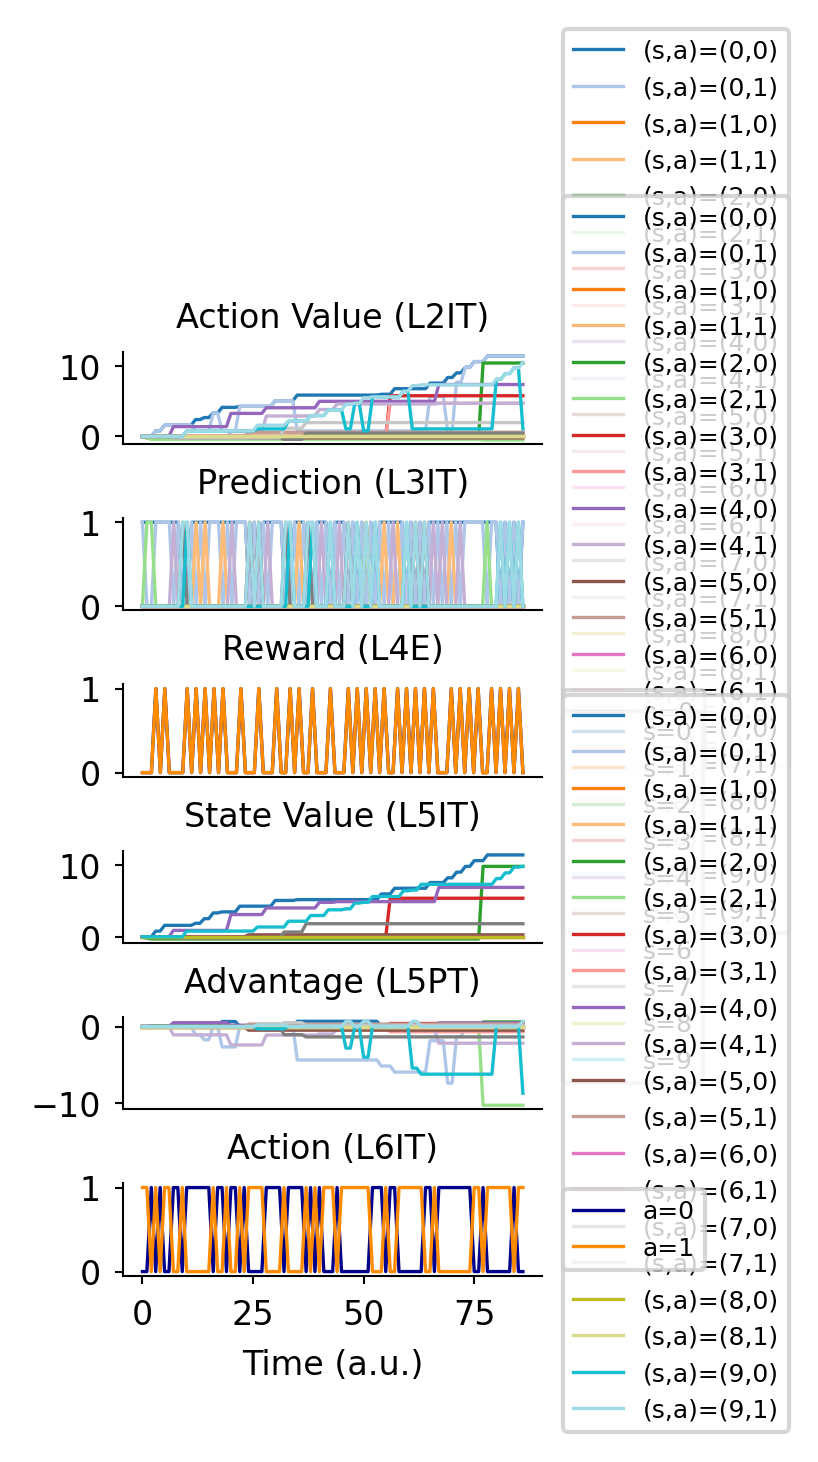

In [13]:

agent_obj = pgq_grid

action_value_array = np.array(agent_obj.agent.logged_action_value_all)
next_state_prediction_array = np.array(agent_obj.agent.logged_next_states_one_hot)
reward_next_array = np.array(agent_obj.agent.logged_reward_next_all)
state_value_array = np.array(agent_obj.agent.logged_state_value_all)
advantage_array = np.array(agent_obj.agent.logged_advantage_all)
action_array = np.array(agent_obj.agent.logged_action_one_hot)

t_array = np.arange(len(state_value_array))
max_t = len(t_array) - 1
opto_t = len(t_array) // 2 if opto in ("L2IT", "L5IT") else None

multi_column_data = [
    (action_value_array, 'Action Value (L2IT)'),
    (next_state_prediction_array, 'Prediction (L3IT)', t_array[1:]),
    (reward_next_array, 'Reward (L4E)', t_array[1:]),
    (state_value_array, 'State Value (L5IT)'),
    (advantage_array, 'Advantage (L5PT)'),
    (action_array, 'Action (L6IT)')
]

# Match panel size and style
fig, ax = plt.subplots(6, 1, figsize=(1.8, 4.0), dpi=300)

title_fontsize = 8
label_fontsize = 8
tick_fontsize = 8
line_width = 0.8

colors_2 = ['darkblue', 'darkorange']
colors_8 = list(plt.cm.tab10.colors)

for i, item in enumerate(multi_column_data):
    data = item[0]
    title = item[1]
    t = item[2] if len(item) > 2 else t_array

    if data.ndim == 2:
        n_col = data.shape[1]
        if n_col in (6,10):
            selected_colors = colors_8
        elif n_col == 2:
            selected_colors = colors_2
        else:
            selected_colors = plt.cm.tab20.colors
        for j in range(n_col):
            if n_col == 2:
                label = f'a={j}'
            elif n_col == 20:
                s = j // 2
                a = j % 2
                label = f'(s,a)=({s},{a})'
            elif n_col == 10:
                s = j // 2
                a = j % 2
                label = f's={j}'
            else:
                label = f'dim={j}'
            ax[i].plot(t, data[:len(t), j], linewidth=line_width,
                        color=selected_colors[j % len(selected_colors)],
                        label=label)
            ax[i].legend(fontsize=6, loc='center left', bbox_to_anchor=(1.02, 0.5))
        if i == len(ax) - 1:
            ax[i].legend(fontsize=6, loc='center left', bbox_to_anchor=(1.02, 0.5))

    if opto_t is not None:
        ax[i].axvline(x=opto_t, color='black', linestyle='--', linewidth=0.8,
                      label='Opto onset' if i == 0 else None)

    ax[i].set_title(title, fontsize=title_fontsize)
    ax[i].tick_params(labelsize=tick_fontsize)


    # Remove spines
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    if i < len(ax) - 1:
        ax[i].tick_params(labelbottom=False, bottom=False)
    else:
        ax[i].set_xlabel("Time (a.u.)", fontsize=label_fontsize)

    ax[i].grid(False)

plt.subplots_adjust(hspace=0.8)
plt.savefig(f"{env_type.lower()}_all_dynamics.svg", format="svg", bbox_inches="tight")
plt.show()
plt.close()

# CAI simulations for quantification

In [14]:
num_episodes = 40
tmax = 8
window_size = 1
n_runs = num_repeats

cumulative_rewards_all = []
all_levels_for_runs = []
all_pushpulls_for_runs = []
all_V = []
all_Advantage = []

episode_lengths_by_condition = defaultdict(list)
full_analysis_data = defaultdict(list)

for i in range(num_repeats):
    if opto in ("L2IT", "L5IT"):
        rl = RL(LeverPushPullTrial, CAI, 10, 2, env_type="LeverPushPullTrial", tmax=100, opto=opto)
    else:
        rl = RL(LeverPushPullTrial, CAI, 10, 2, env_type="LeverPushPullTrial", tmax=100, opto=None)
    pushpulls = np.random.randint(0,2,num_episodes)
    levels = np.random.choice([0, 1, 2], size=num_episodes, p=[0.5, 0.25, 0.25])
    all_levels_for_runs.append(levels)
    all_pushpulls_for_runs.append(pushpulls)
    rl.agent.beta = 10

    cumulative_rewards = []
    V_episode = [rl.agent.V.copy()]
    Advantage_episode = [rl.agent.Advantage.copy()]

    for ep in range(1, num_episodes + 1):
        current_pushpull = pushpulls[ep-1]
        current_level = levels[ep-1]
        rl.agent.pushpull = current_pushpull
        rl.agent.level = current_level
        rl.env.pushpull = current_pushpull
        rl.env.level = current_level
        trsa = rl.episode2(tmax=tmax) if opto in ("L2IT", "L5IT") and ep > num_episodes//2 else rl.episode(tmax=tmax)
        cum_reward = np.sum(trsa[:, 1])
        cumulative_rewards.append(cum_reward)

        success = 1 if cum_reward > 0 else 0
        episode_length = len(trsa)

        first_action = trsa[0, 3]
        initial_error = 1 if first_action != current_pushpull else 0

        trial_info = {
            'success': success,
            'duration': episode_length,
            'initial_error': initial_error
        }
        full_analysis_data[current_level].append(trial_info)
        condition_key = (current_pushpull, current_level)
        episode_lengths_by_condition[condition_key].append(episode_length)

        if ep % 10 == 0:
            V_episode.append(rl.agent.V.copy())
            Advantage_episode.append(rl.agent.Advantage.copy())

    cumulative_rewards_all.append(np.array(cumulative_rewards))
    all_V.append(V_episode)
    all_Advantage.append(Advantage_episode)

mean_rewards = np.mean(cumulative_rewards_all, axis=0)
std_rewards = np.std(cumulative_rewards_all, axis=0, ddof=1)
CI_low_accuracy, CI_high_accuracy = proportion_confint(np.sum(cumulative_rewards_all,axis=0), np.size(cumulative_rewards_all,axis=0), alpha=0.05, method='wilson')

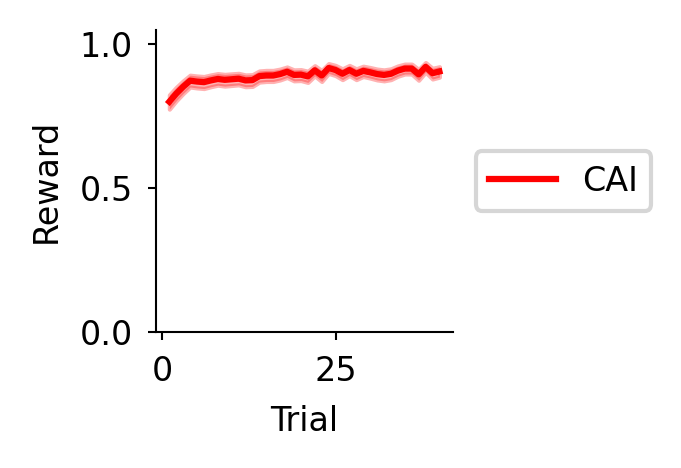

In [15]:

# === (1) Plot cumulative rewards  ===
fig, ax = plt.subplots(figsize=(2.4, 1.6), dpi=300)
episodes = np.arange(1, num_episodes + 1)

# CAI (red)
ax.plot(episodes, mean_rewards, label='CAI', color='red', linewidth=1.5)
ax.fill_between(episodes, CI_low_accuracy, CI_high_accuracy,
                color='red', alpha=0.3)

# Axes labels and ticks
ax.set_xlabel('Episode', fontsize=8) if env_type == "GridWorld" else ax.set_xlabel('Trial', fontsize=8)
ax.set_ylabel('Reward', fontsize=8)
ax.tick_params(labelsize=8)
ax.set_ylim(0.0, 1.05)

# Remove grid and spines
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Legend outside right
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=8)

# Layout and save
plt.tight_layout()
plt.savefig("gridworld_cumulative_reward_CI.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()

# === (4) Success Rate by Level  =========================
# ── Calculate success rates for each level across all runs ──
success_rates_by_level_all_runs = []

for i in range(num_repeats):
    run_rewards = cumulative_rewards_all[i]
    run_levels = all_levels_for_runs[i]

    # Outcomes for this specific run
    run_outcomes = {0: [], 1: [], 2: []}
    for ep in range(num_episodes):
        level = run_levels[ep]
        reward = run_rewards[ep]
        success = 1 if reward > 0 else 0
        run_outcomes[level].append(success)

    # Calculate success rate for this run, handling missing levels
    run_success_rates = {}
    for level in [0, 1, 2]:
        if run_outcomes[level]:
            run_success_rates[level] = np.mean(run_outcomes[level])
        else:
            run_success_rates[level] = np.nan
    success_rates_by_level_all_runs.append(run_success_rates)

# ── Aggregate mean ──
mean_rates = []
std_rates = []
level_labels = ['Easy', 'Medium', 'Hard']

for level in [0, 1, 2]:
    rates_for_level = [run[level] for run in success_rates_by_level_all_runs if not np.isnan(run[level])]
    if rates_for_level:
        mean_rates.append(np.mean(rates_for_level))
        std_rates.append(np.std(rates_for_level))
    else:
        mean_rates.append(0)
        std_rates.append(0)

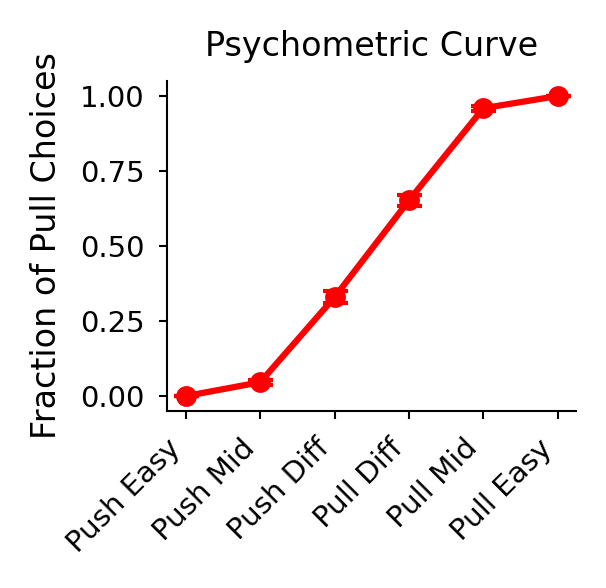

In [16]:
# === (5) Psychometric Curve for LeverPushPullTrial =========================
# ── 1. Calculate success rates for each condition across all runs ──
all_trials_data_psycho = []
results_all_runs = []
category_map = {
    (0, 0): 'Push Easy', (0, 1): 'Push Mid', (0, 2): 'Push Diff',
    (1, 0): 'Pull Easy', (1, 1): 'Pull Mid', (1, 2): 'Pull Diff'
}
for i in range(num_repeats):
    run_rewards = cumulative_rewards_all[i]
    run_levels = all_levels_for_runs[i]
    run_pushpulls = all_pushpulls_for_runs[i]

    run_outcomes = {(pp, lvl): [] for pp in [0, 1] for lvl in [0, 1, 2]}

    for ep in range(20,num_episodes):
        condition = (run_pushpulls[ep], run_levels[ep])
        success = 1 if run_rewards[ep] > 0 else 0
        run_outcomes[condition].append(success)

    # Process the raw outcomes and convert to "Pull Choice" (0 or 1)
    for condition, outcomes in run_outcomes.items():
        if not outcomes: continue
        pp, lvl = condition
        for success in outcomes:

            pull_choice = (1 - success) if pp == 0 else success
            all_trials_data_psycho.append({
                'Category': category_map[condition],
                'Pull_Choice': pull_choice
            })

    run_rates = {key: np.mean(val) if val else np.nan for key, val in run_outcomes.items()}
    results_all_runs.append(run_rates)

# ── 2. Aggregate mean ──
final_means = {}
final_stds = {}
# (Push=0, Pull=1) x (Easy=0, Mid=1, Diff=2)
for pp in [0, 1]:
    for lvl in [0, 1, 2]:
        condition = (pp, lvl)
        rates_for_condition = [run.get(condition) for run in results_all_runs]
        rates_for_condition = [r for r in rates_for_condition if not np.isnan(r)]

        if rates_for_condition:
            final_means[condition] = np.mean(rates_for_condition)
            final_stds[condition] = np.std(rates_for_condition)
        else:
            final_means[condition] = np.nan
            final_stds[condition] = np.nan

# ── 3. Prepare data for plotting (in psychometric curve style) ──
mean_accuracies = np.array([final_means.get((0,0)), final_means.get((0,1)), final_means.get((0,2)),
                            final_means.get((1,0)), final_means.get((1,1)), final_means.get((1,2))])
std_accuracies = np.array([final_stds.get((0,0)), final_stds.get((0,1)), final_stds.get((0,2)),
                            final_stds.get((1,0)), final_stds.get((1,1)), final_stds.get((1,2))])

categories = ['Push Easy', 'Push Mid', 'Push Diff', 'Pull Easy', 'Pull Mid', 'Pull Diff']
order = [0, 1, 2, 5, 4, 3]
categories_ordered = [categories[i] for i in order]

mean_choice1_fraction = np.array([
    1 - mean_accuracies[0], 1 - mean_accuracies[1], 1 - mean_accuracies[2], # Push trials
    mean_accuracies[3],     mean_accuracies[4],     mean_accuracies[5]      # Pull trials
])
std_choice1_fraction = std_accuracies


mean_choice1_fraction_ordered = mean_choice1_fraction[order]
std_choice1_fraction_ordered = std_choice1_fraction[order]

plot_psycho_df_temp = pd.DataFrame(all_trials_data_psycho)
plot_psycho_df_temp['Category'] = pd.Categorical(plot_psycho_df_temp['Category'], categories=categories_ordered, ordered=True)
plot_psycho_df = plot_psycho_df_temp.groupby(['Category'], observed=True)['Pull_Choice'].agg(
        successes='sum', nobs='count'
    ).reset_index()
plot_psycho_df['conf_low'], plot_psycho_df['conf_high'] = proportion_confint(
    count=plot_psycho_df['successes'], nobs=plot_psycho_df['nobs'], alpha=0.05, method='wilson'
)
plot_psycho_df['mean'] = plot_psycho_df['successes'] / plot_psycho_df['nobs']
plot_psycho_df['std'] = np.sqrt(plot_psycho_df['mean'] * (1 - plot_psycho_df['mean']) / plot_psycho_df['nobs'])
yerr_high = abs(plot_psycho_df['conf_high']-plot_psycho_df['mean'])
yerr_low = abs(plot_psycho_df['mean'] - plot_psycho_df['conf_low'])
plot_psycho_df['CI_accuracy'] = abs(plot_psycho_df['conf_high'] - plot_psycho_df['mean'])
plot_psycho_df['yerr'] = list(zip(yerr_low, yerr_high))
plot_psycho_df = plot_psycho_df.sort_values('Category')

file_path = 'behavior_psychometric_data_CI.csv'
plot_psycho_df.to_csv(file_path, index=False, encoding='utf-8-sig')


# ── 4. Plot the psychometric curve ──
fig, ax = plt.subplots(figsize=(2.0, 2.0), dpi=300)
x = np.arange(6)

asymmetric_error = np.array(plot_psycho_df['yerr'].tolist()).T
ax.errorbar(x, plot_psycho_df['mean'],
            yerr=asymmetric_error,
            color='red',
            linewidth=1.5,
            marker='o',
            markersize=4,
            capsize=3)

ax.set_ylabel('Fraction of Pull Choices', fontsize=8)
ax.set_title('Psychometric Curve', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(categories_ordered, rotation=45, ha='right')
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("leverpushpull_psychometric_curve.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()

In [17]:
# --- Analysis 2 & 3: After Initial Error ---
success_rate_after_error = []; success_rate_lucky = []
duration_after_error_mean = []; duration_lucky_mean = []
duration_after_error_std = [];duration_lucky_std = []
success_rate_after_error_CI = [];success_rate_lucky_CI = []
level_labels = ['Easy', 'Mid', 'Diff']

for level in sorted(full_analysis_data.keys()):
    error_trials = [t for t in full_analysis_data[level] if t['initial_error'] == 1]
    lucky_trials = [t for t in full_analysis_data[level] if t['initial_error'] == 0]

    if not error_trials:
        success_rate_after_error.append(np.nan)
        duration_after_error_mean.append(np.nan)
        duration_after_error_std.append(np.nan)
        continue

    successes = [t['success'] for t in error_trials]; lucky_successes = [t['success'] for t in lucky_trials]
    durations = [t['duration'] for t in error_trials]; lucky_durations = [t['duration'] for t in lucky_trials]
    success_rate_after_error.append(np.mean(successes)); success_rate_lucky.append(np.mean(lucky_successes))
    duration_after_error_mean.append(np.mean(durations)-1); duration_lucky_mean.append(np.mean(lucky_durations)-1)
    duration_after_error_std.append(np.std(durations) if len(durations) > 1 else 0); duration_lucky_std.append(np.std(lucky_durations) if len(lucky_durations) > 1 else 0)
    CI_successes_error_low, CI_successes_error_high = proportion_confint(np.sum(successes), len(successes), alpha=0.05, method='wilson')
    CI_successes_lucky_low, CI_successes_lucky_high = proportion_confint(np.sum(lucky_successes), len(lucky_successes), alpha=0.05, method='wilson')
    success_rate_after_error_CI.append(abs(CI_successes_error_high-np.mean(successes))); success_rate_lucky_CI.append(abs(CI_successes_lucky_high-np.mean(lucky_successes)))

df2 = pd.DataFrame({
    'Difficulty': level_labels,
    'Success_Rate_After_Error': success_rate_after_error,
    'Mean_Duration_After_Error': duration_after_error_mean,
    'STD_Duration_After_Error': duration_after_error_std,
    'Success_Rate_Lucky': success_rate_lucky,
    'Mean_Duration_Lucky': duration_lucky_mean,
    'STD_Duration_Lucky': duration_lucky_std,
    'CI_Success_Rate_After_Error': success_rate_after_error_CI,
    'CI_Success_Rate_Lucky': success_rate_lucky_CI
})
df2.to_csv("analysis_lucky_unlucky_success_CI.csv", index=False)

In [18]:
from scipy import stats

level_labels = ['Easy', 'Mid', 'Diff']
no_error_means, no_error_stds = [], []
with_error_means, with_error_stds = [], []
no_error_CI, with_error_CI = [], []

for level in sorted(full_analysis_data.keys()):
    trials = full_analysis_data[level]

    successful_trials = [t for t in trials if t['success'] == 1]

    durations_no_error = [t['duration'] for t in successful_trials if t['initial_error'] == 0]
    durations_with_error = [t['duration'] for t in successful_trials if t['initial_error'] == 1]

    no_error_means.append(np.mean(durations_no_error)-1 if durations_no_error else np.nan)
    no_error_stds.append(np.std(durations_no_error) if len(durations_no_error) > 1 else 0)
    CI_no_error_low, CI_no_error_high = stats.t.interval(0.95,df=len(durations_no_error)-1, loc=np.mean(durations_no_error)-1, scale=stats.sem(durations_no_error))
    no_error_CI.append(abs(CI_no_error_high-np.mean(durations_no_error)+1))

    with_error_means.append(np.mean(durations_with_error)-1 if durations_with_error else np.nan)
    with_error_stds.append(np.std(durations_with_error) if len(durations_with_error) > 1 else 0)
    CI_with_error_low, CI_with_error_high = stats.t.interval(0.95,df=len(durations_with_error)-1, loc=np.mean(durations_with_error)-1, scale=stats.sem(durations_with_error))
    with_error_CI.append(abs(CI_with_error_high-np.mean(durations_with_error)+1))

df_plot_data = pd.DataFrame({
    'Difficulty': level_labels,
    'Mean_Duration_No_Error': no_error_means,
    'STD_Duration_No_Error': no_error_stds,
    'Mean_Duration_With_Error': with_error_means,
    'STD_Duration_With_Error': with_error_stds,
    'CI_Duration_No_Error': no_error_CI,
    'CI_Duration_With_Error': with_error_CI
})

csv_filename = "success_duration_by_initial_error_CI.csv"
df_plot_data.to_csv(csv_filename, index=False, encoding='utf-8-sig')

/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-2482290349.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  CI_with_error_low, CI_with_error_high = stats.t.interval(0.95,df=len(durations_with_error)-1, loc=np.mean(durations_with_error)-1, scale=stats.sem(dura

In [19]:
opto_conditions = [None, 'L2IT', 'L5IT']
all_plot_data = {}
categories_ordered = ['Push Easy', 'Push Mid', 'Push Diff', 'Pull Diff', 'Pull Mid', 'Pull Easy']
categories = ['Push Easy', 'Push Mid', 'Push Diff', 'Pull Easy', 'Pull Mid', 'Pull Diff']
xticklabels = ['1:8','1:4','1:2','2:1','4:1','8:1']
order = [0, 1, 2, 5, 4, 3]
all_run_outcomes_for_stats = []
category_map = {
    (0, 0): 'Push Easy', (0, 1): 'Push Mid', (0, 2): 'Push Diff',
    (1, 0): 'Pull Easy', (1, 1): 'Pull Mid', (1, 2): 'Pull Diff'
}
all_trials_data = []

print("Starting simulations...")
for opto in opto_conditions:
    opto_name = "Control" if opto is None else opto
    print(f"--- Running simulation for opto = '{opto_name}' ---")

    cumulative_rewards_all = []
    all_levels_for_runs = []
    all_pushpulls_for_runs = []

    for i in range(num_repeats):
        rl = RL(LeverPushPullTrial, CAI,10, 2, env_type="LeverPushPullTrial", tmax=8, opto=opto)
        rl.agent.beta = 10

        pushpulls = np.random.randint(0, 2, num_episodes)
        levels = np.random.choice([0, 1, 2], size=num_episodes, p=[0.5, 0.25, 0.25])
        all_levels_for_runs.append(levels)
        all_pushpulls_for_runs.append(pushpulls)

        cumulative_rewards = []
        for ep in range(num_episodes):
            current_pushpull = pushpulls[ep]
            current_level = levels[ep]
            rl.agent.pushpull = current_pushpull
            rl.agent.level = current_level
            rl.env.pushpull = current_pushpull
            rl.env.level = current_level

            trsa = rl.episode2(tmax=8) if opto in ("L2IT", "L5IT")  and ep > num_episodes//2 else rl.episode(tmax=8)
            cum_reward = np.sum(trsa[:, 1])
            cumulative_rewards.append(cum_reward)

        cumulative_rewards_all.append(np.array(cumulative_rewards))

    # --- Collect raw trial data from the simulation runs for the current condition ---

    results_all_runs = []

    for i in range(num_repeats):
        run_rewards = cumulative_rewards_all[i]
        run_levels = all_levels_for_runs[i]
        run_pushpulls = all_pushpulls_for_runs[i]

        run_outcomes = {(pp, lvl): [] for pp in [0, 1] for lvl in [0, 1, 2]}

        for ep in range(num_episodes // 2, num_episodes):
            condition = (run_pushpulls[ep], run_levels[ep])
            success = 1 if run_rewards[ep] > 0 else 0
            run_outcomes[condition].append(success)

        # Process the raw outcomes and convert to "Pull Choice" (0 or 1)
        for condition, outcomes in run_outcomes.items():
            if not outcomes: continue
            pp, lvl = condition
            for success in outcomes:
                pull_choice = (1 - success) if pp == 0 else success
                all_trials_data.append({
                    'Condition': opto_name,
                    'Category': category_map[condition],
                    'Pull_Choice': pull_choice
                })
        run_rates = {key: np.mean(val) if val else np.nan for key, val in run_outcomes.items()}
        results_all_runs.append(run_rates)

    for run_rates in results_all_runs:
        for condition, success_rate in run_rates.items():
            if np.isnan(success_rate): continue
            pp, lvl = condition
            pull_fraction = (1 - success_rate) if pp == 0 else success_rate
            all_run_outcomes_for_stats.append({
                'Condition': opto_name,
                'Category': category_map[condition],
                'Pull_Fraction': pull_fraction
            })

    final_means = {}
    final_stds = {}
    for pp in [0, 1]:
        for lvl in [0, 1, 2]:
            condition = (pp, lvl)
            rates_for_condition = [run.get(condition, np.nan) for run in results_all_runs]
            rates_for_condition = [r for r in rates_for_condition if not np.isnan(r)]

            if rates_for_condition:
                final_means[condition] = np.mean(rates_for_condition)
                final_stds[condition] = np.std(rates_for_condition, ddof=1)
            else:
                final_means[condition] = np.nan
                final_stds[condition] = np.nan

    mean_accuracies = np.array([final_means.get((0,0)), final_means.get((0,1)), final_means.get((0,2)),
                                final_means.get((1,0)), final_means.get((1,1)), final_means.get((1,2))])
    std_accuracies = np.array([final_stds.get((0,0)), final_stds.get((0,1)), final_stds.get((0,2)),
                              final_stds.get((1,0)), final_stds.get((1,1)), final_stds.get((1,2))])

    mean_choice1_fraction = np.array([
        1 - mean_accuracies[0], 1 - mean_accuracies[1], 1 - mean_accuracies[2],
        mean_accuracies[3],     mean_accuracies[4],     mean_accuracies[5]
    ])
    std_choice1_fraction = std_accuracies

    mean_choice1_fraction_ordered = mean_choice1_fraction[order]
    std_choice1_fraction_ordered = std_choice1_fraction[order]

    all_plot_data[opto] = {
        'means': mean_choice1_fraction_ordered,
        'stds': std_choice1_fraction_ordered
    }

print("...All simulations complete.")

Starting simulations...
--- Running simulation for opto = 'Control' ---
--- Running simulation for opto = 'L2IT' ---
--- Running simulation for opto = 'L5IT' ---
...All simulations complete.



     STATISTICAL ANALYSIS (Chi-squared test)     

--- Analyzing Category: Push Easy ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Performing post-hoc tests...
Post-hoc results (Bonferroni-corrected p-values):
  Control vs L2IT: p = 0.0000
  Control vs L5IT: p = 0.0041
  L2IT vs L5IT: p = 0.3205

--- Analyzing Category: Push Mid ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Performing post-hoc tests...
Post-hoc results (Bonferroni-corrected p-values):
  Control vs L2IT: p = 0.0000
  Control vs L5IT: p = 0.0000
  L2IT vs L5IT: p = 0.0000

--- Analyzing Category: Push Diff ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Performing post-hoc tests...
Post-hoc results (Bonferroni-corrected p-values):
  Control vs L2IT: p = 0.0000
  Control vs L5IT: p = 0.0013
  L2IT vs L5IT: p = 0.0000

--- Analyzing Category: Pull Diff ---
Overall Chi-squared test: p-value = 0.0000
Significant difference found. Perf

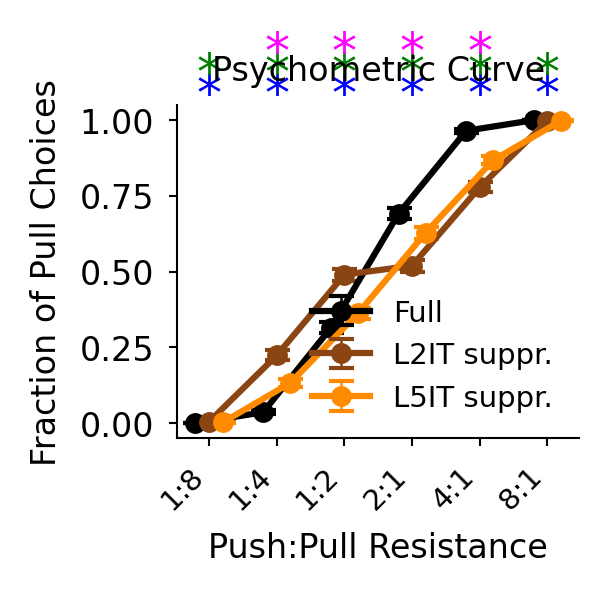

In [20]:
# --- Create a single DataFrame containing data from ALL conditions ---
stats_df = pd.DataFrame(all_trials_data)
if stats_df.empty:
    print("Error: No data was generated from simulations.")
else:
    stats_df['Category'] = pd.Categorical(stats_df['Category'], categories=categories_ordered, ordered=True)

    # --- 2. Statistical Analysis (Chi-squared test on the complete dataset) ---
    test_results = []
    print("\n" + "="*50)
    print("     STATISTICAL ANALYSIS (Chi-squared test)     ")
    print("="*50 + "\n")

    for category in categories_ordered:
        print(f"--- Analyzing Category: {category} ---")
        category_df = stats_df[stats_df['Category'] == category]
        contingency_table = pd.crosstab(category_df['Condition'], category_df['Pull_Choice'])

        if contingency_table.shape[0] < 2:
            print("Skipping: Not enough conditions to compare.\n")
            continue

        chi2, p_val, _, _ = chi2_contingency(contingency_table)
        print(f"Overall Chi-squared test: p-value = {p_val:.4f}")

        if p_val < 0.05:
            print("Significant difference found. Performing post-hoc tests...")
            condition_pairs = list(combinations(contingency_table.index, 2))
            uncorrected_p_values = []
            for pair in condition_pairs:
                pair_table = contingency_table.loc[list(pair)]
                try:
                    _, p_uncorrected, _, _ = chi2_contingency(pair_table)
                    uncorrected_p_values.append(p_uncorrected)
                except ValueError as e:
                    print(f"  Skipping pair {pair} for category '{category}'. Reason: {e}")
                    uncorrected_p_values.append(1.0)

            reject, p_corrected, _, _ = multipletests(uncorrected_p_values, alpha=0.05, method='bonferroni')
            print("Post-hoc results (Bonferroni-corrected p-values):")
            for i, pair in enumerate(condition_pairs):
                print(f"  {pair[0]} vs {pair[1]}: p = {p_corrected[i]:.4f}")
                if p_corrected[i] < 0.05:
                    sorted_pair = sorted(pair)
                    comparison_str = f"{sorted_pair[0]}_vs_{sorted_pair[1]}"
                    test_results.append({
                        'Category': category, 'Comparison': comparison_str,
                        'P-value (Bonferroni)': p_corrected[i], 'Significant (p < 0.05)': True
                    })
            print()
        else:
            print("No significant overall difference.\n")

    results_table = pd.DataFrame(test_results)

    # --- 3. Create DataFrame for Plotting (with 95% CIs) ---
    plot_df = stats_df.groupby(['Condition', 'Category'], observed=True)['Pull_Choice'].agg(
        successes='sum', nobs='count'
    ).reset_index()

    plot_df['conf_low'], plot_df['conf_high'] = proportion_confint(
        count=plot_df['successes'], nobs=plot_df['nobs'], alpha=0.05, method='wilson'
    )
    plot_df['mean'] = plot_df['successes'] / plot_df['nobs']
    yerr_low = abs(plot_df['mean'] - plot_df['conf_low'])
    yerr_high = abs(plot_df['conf_high'] - plot_df['mean'])
    plot_df['yerr'] = list(zip(yerr_low, yerr_high))
    plot_df['Condition'] = pd.Categorical(plot_df['Condition'], categories=["Control", "L2IT", "L5IT"], ordered=True)
    plot_df = plot_df.sort_values('Condition')

    # --- 4. Plotting and Drawing Significance Stars ---
    fig, ax = plt.subplots(figsize=(2.0, 2.1), dpi=300)
    x = np.arange(len(categories_ordered))
    colors = {'Control': 'black', 'L2IT': 'saddlebrown', 'L5IT': 'darkorange'}
    labels_plot = {'Control': 'Full', 'L2IT': 'L2IT suppr.', 'L5IT': 'L5IT suppr.'}
    num_conditions = len(plot_df['Condition'].unique()); dodge_width = 0.4

    for i, (condition_name, group_df) in enumerate(plot_df.groupby('Condition', observed=True)):
        group_df['Category'] = pd.Categorical(group_df['Category'], categories=categories_ordered, ordered=True)
        group_df = group_df.sort_values('Category')
        offset = dodge_width * (i / (num_conditions - 1) - 0.5) if num_conditions > 1 else 0
        asymmetric_error = np.array(group_df['yerr'].tolist()).T
        ax.errorbar(x + offset, group_df['mean'], yerr=asymmetric_error, fmt='-o', color=colors.get(condition_name, 'black'),
                    linewidth=1.5, markersize=4, capsize=3, elinewidth=0.6, alpha=1.0, label=labels_plot.get(condition_name))

    if not results_table.empty:
        y_base=1.08; y_increment=0.07
        category_to_x = {cat: i for i, cat in enumerate(categories_ordered)}
        comparison_styles = {'Control_vs_L2IT': {'color': 'blue', 'marker': '*'},'Control_vs_L5IT': {'color': 'green', 'marker': '*'},'L2IT_vs_L5IT': {'color': 'magenta', 'marker': '*'}}
        for _, row in results_table.iterrows():
            category, comparison = row['Category'], row['Comparison']
            x_pos = category_to_x[category]
            y_pos = y_base
            if comparison == 'Control_vs_L5IT': y_pos += y_increment
            if comparison == 'L2IT_vs_L5IT': y_pos += y_increment * 2
            style = comparison_styles.get(comparison, {'color': 'black', 'marker': '*'})
            ax.text(x_pos, y_pos, style['marker'], color=style['color'], fontsize=12, ha='center', va='center')

    ax.set_xlabel('Push:Pull Resistance', fontsize=8)
    ax.set_ylabel('Fraction of Pull Choices', fontsize=8)
    ax.set_title('Psychometric Curve', fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=7)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(frameon=False, fontsize=7)
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig("psychometric_curve_final.svg", format="svg", bbox_inches='tight')
    plt.show()
    plt.close()